https://drive.google.com/drive/u/0/folders/1D4ifn_scE2ATOKc4GCrm227Toi8_hWKa

<center> <b>Machine Learning - SBU FALL 2024</b></center>

In [ ]:
student_number = '99243022'
Name = 'Masoume'
Last_Name = 'Pasebani'


# MobileNet V1: A PyTorch Tutorial



In this notebook, we present a comprehensive guide to understanding and implementing the MobileNet V1 architectures using PyTorch. MobileNet is a highly regarded family of deep learning architectures, designed by Google with a primary focus on creating models that are both lightweight and computationally efficient. These models are particularly optimized for mobile and embedded devices, where resources like memory, processing power, and battery life are often limited.

MobileNet stands out for its unique design principles, particularly the use of depthwise separable convolutions, which significantly reduce the number of parameters and computation required compared to traditional convolutional neural networks. This makes MobileNet an ideal choice for applications that demand real-time performance, such as mobile apps, IoT devices, and on-device machine learning tasks.

Another application for MobileNet is edge deployment. Its scalable architecture allows customization through width and resolution multipliers, making it adaptable to the resource constraints of various devices. Additionally, MobileNet's low power consumption is ideal for battery-operated systems, and its compatibility with frameworks like TensorFlow Lite and hardware accelerators like Edge TPUs ensures seamless deployment. These features make it perfect for real-time, on-device applications such as object detection, face recognition, and other AI tasks at the edge.

Throughout this notebook, we will delve into both MobileNet V1 architectures, examining how each version builds on the previous one to enhance both efficiency and accuracy. By implementing these architectures step-by-step in PyTorch, we aim to provide a solid foundation for anyone interested in leveraging MobileNet’s capabilities for mobile and edge computing applications.

### Objectives
- Understand the structure and advantages of MobileNet V1
- Learn the theory of depthwise separable convolutions and inverted residuals
- Implement and use MobileNet V1 in PyTorch
- Use transfer learning for better accuracy


![architecture](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fs41598-024-53349-w/MediaObjects/41598_2024_53349_Fig2_HTML.png)

## 1. MobileNet V1

### Theory
MobileNet V1 was designed by Google to create an efficient and lightweight neural network model for mobile and embedded applications. The architecture is built on **depthwise separable convolutions**, which reduce computation cost and model size compared to traditional convolutions.

- **Depthwise Separable Convolution**: A depthwise separable convolution splits a standard convolution into two parts:
  1. **Depthwise Convolution**: This operation applies a single filter to each input channel independently. It significantly reduces computation by processing each channel separately.
  2. **Pointwise Convolution (1x1 Convolution)**: This operation combines the channels outputted by the depthwise convolution by applying a 1x1 filter. It performs a linear combination across the channels, allowing the model to learn interactions between different channels.

To learn more about this convolution you can check this [link](https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec)


Compared to traditional convolution, which combines spatial and channel information simultaneously, depthwise separable convolutions drastically reduce the number of computations.

MobileNet V1 also introduces two scaling hyperparameters:
- **Width Multiplier** (α): Scales the number of channels in each layer, allowing you to shrink the model's width (number of channels).
- **Resolution Multiplier** (ρ): Reduces the resolution of the input image, further decreasing computational cost.


Now let's implement a MobileNet from scratch. Start by importing the necessary libraries.

In [ ]:
# Importing libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

import torchvision
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Subset
from typing import Tuple, List
from torch.optim import Optimizer
from torch.utils.data import DataLoader, SubsetRandomSampler


Check your device. We recommend using GPU. You can use GPU with google colab.

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


Before starting we want you to have some knowledge about Batch Normalization.

### **Understanding Batch Normalization**

Batch Normalization (BatchNorm) is a technique designed to improve the training of deep neural networks by normalizing the inputs to each layer. It helps address the issue of "internal covariate shift," where the distribution of activations changes as training progresses.

Batch Normalization consists of two main steps: **Normalization** and **Scaling/Shift**.

### 1. **Normalization**

Given a batch of data $X$ with $m$ samples and $n$ features, Batch Normalization first computes the **mean** ($\mu$) and **variance** ($\sigma^2$) for each feature across the batch:

$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i, \quad
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

Each feature is then normalized using:

$$
\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$

where:
- $\epsilon$: A small constant added to avoid division by zero.



### 2. **Scaling and Shifting**

To allow the model to learn the optimal feature representation, the normalized value $\hat{x}_i$ is scaled and shifted using learnable parameters $\gamma$ (scale) and $\beta$ (shift):

$$
y_i = \gamma \hat{x}_i + \beta
$$



### **Complete Formula**

The full Batch Normalization transformation for each feature is:

$$
y_i = \gamma \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$



## **Why Use Batch Normalization?**

1. **Stabilizes Training**: By normalizing inputs, gradients are more stable, which accelerates convergence.
2. **Reduces Dependence on Initialization**: Makes the network less sensitive to weight initialization.
3. **Acts as a Regularizer**: Introduces noise due to batch statistics, helping reduce overfitting.
4. **Improves Generalization**: Often eliminates the need for other regularization techniques like Dropout.



Batch normalization is a technique used to improve the training speed and stability of deep neural networks by normalizing the input data within each mini-batch. It helps to address issues such as internal covariate shift, where the distribution of activations varies during training. By normalizing the inputs, batch normalization enables higher learning rates and reduces the need for careful initialization.

Mean Calculation: The mean of the input data x is computed along the feature axis (axis=0). This represents the average value for each feature across the batch.

Variance Calculation: The variance of the input data is also computed along the feature axis. This measures the spread of the data points around the mean.

Normalization: The input data x is normalized by subtracting the mean and dividing by the standard deviation (which is the square root of the variance plus a small constant epsilon to avoid division by zero). This operation ensures that the input features have zero mean and unit variance.

Scaling and Shifting: After normalization, the data is scaled by the parameter gamma (the scale factor) and shifted by the parameter beta (the shift factor). These parameters are learned during training, allowing the model to adjust the normalized data.

Output: The final output is the normalized and scaled data, which is returned.

In [ ]:
def batch_normalization(x, gamma, beta, epsilon=1e-5):
    """
    Performs batch normalization on the input data.

    Parameters:
        x (numpy.ndarray): Input data of shape (batch_size, features).
        gamma (float): Scale parameter.
        beta (float): Shift parameter.
        epsilon (float): Small value to avoid division by zero.

    Returns:
        numpy.ndarray: Normalized and scaled data.
    """
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)

    x2 = x - mean
    dev = np.sqrt(var + epsilon)
    normalized_x = x2 / dev

    scaled_x = np.multiply(normalized_x, gamma)
    out = scaled_x + beta

    return out


In [ ]:
# Example batch data (4 samples, 3 features)
x = np.array([[1.0, 2.0, 3.0],
              [4.0, 5.0, 6.0],
              [7.0, 8.0, 9.0],
              [10.0, 11.0, 12.0]])

# Parameters for scaling and shifting
gamma = 1.0
beta = 0.0

# Apply batch normalization
normalized_data = batch_normalization(x, gamma, beta)

# Print results
print("Original Data:\n", x)
print("\nNormalized Data:\n", normalized_data)

Original Data:
 [[ 1.  2.  3.]
 [ 4.  5.  6.]
 [ 7.  8.  9.]
 [10. 11. 12.]]

Normalized Data:
 [[-1.34164019 -1.34164019 -1.34164019]
 [-0.4472134  -0.4472134  -0.4472134 ]
 [ 0.4472134   0.4472134   0.4472134 ]
 [ 1.34164019  1.34164019  1.34164019]]


We need some data for training, testing and validation. in this part we use CIFAR-10 dataset. It is a famous dataset in vision. CIFAR-10 contains 60,000 32x32 images in 10 classes.

> **Note**: MobileNet models perform best on larger image sizes (like 224x224), but CIFAR-10 is used here as a simple example dataset.


In this section, data preprocessing steps are applied to the CIFAR-10 dataset, followed by the creation of data loaders for both training and validation. These data loaders are crucial for feeding batches of data to a neural network during training and evaluation.

1. Transforms for Data Augmentation and Normalization
Training Transforms (transform_train): The training data undergoes several transformations to increase the diversity of the dataset, allowing the model to generalize better:

Random Resized Crop: Crops a random region of the image and resizes it to 224x224 pixels. The crop size varies between 50% and 100% of the original image dimensions (scale=(0.5, 1.0)), which introduces variety in the training images.
Random Horizontal Flip: Randomly flips the image horizontally with a probability of 50%. This transformation further helps the model generalize by introducing different orientations.
ToTensor: Converts the image into a PyTorch tensor. This is required as PyTorch models expect data in tensor format.
Normalize: Normalizes the image pixel values using the provided mean and standard deviation for each channel (RGB). This step ensures that the data distribution remains centered around 0 with unit variance, which helps with training stability.
Test Transforms (transform_test): The test data undergoes fewer transformations since data augmentation is generally not applied to validation and test sets:

Resize: The test images are resized to a fixed size of 224x224 pixels.
ToTensor: Converts the image into a tensor.
Normalize: Normalizes the test data using the same mean and standard deviation values used for the training set.
2. Training Data (train_set)
The CIFAR-10 training dataset is downloaded and transformed using the defined transform_train.
train_set is an instance of torchvision.datasets.CIFAR10, which includes images and labels for the 10 classes in the dataset.
The train_set object provides access to the training data and labels.
3. Subset of Training Data for Dataloader
The training data is split to create a new subset of data. Only half of the original training dataset is used:
train_len = len(train_set): The total number of samples in the training set.
np.random.choice(train_len, size=train_len//2, replace=False): Randomly selects half of the samples without replacement.
SubsetRandomSampler(i): A sampler that selects a subset of the data based on the random indices generated.
DataLoader (train_l): A DataLoader is created for the training data using a batch size of 64 and the sampler sample:
batch_size=64: Defines how many images are processed in each iteration.
shuffle=False: The data is not shuffled, as we are using a subset sampler that already randomizes the data.
This dataloader feeds the model with batches of data during training.
4. Validation Data (val_set)
The validation set is loaded from CIFAR-10 without any data augmentation, using the transform_test.

val_set is an instance of torchvision.datasets.CIFAR10, which is automatically downloaded with the test data.

DataLoader (val_l): A DataLoader is created for the validation data:

batch_size=128: Defines the number of images per batch for validation.
shuffle=False: Shuffling is not required for validation as the data is used for evaluation after training.
This dataloader allows the model to process batches of validation data during evaluation.
Summary
Transformations: Data augmentation is applied to the training data to improve model generalization, while the test data is only resized and normalized.
Data Subset: A subset of the training data is created by randomly selecting half of the available data, which is then passed through a dataloader for batch processing.
DataLoaders: train_l and val_l are created for training and validation, respectively, to efficiently feed data into the model during training and evaluation phases. The batch sizes are set to 64 for training and 128 for validation.

In [ ]:
# TRANSFORMS
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])

transform_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408],
                         std=[0.2675, 0.2565, 0.2761]),
])


# TRAIN DATA
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# TODO: create train data loader without shuffle with just half of the data

train_len = len(train_set)
i = np.random.choice(train_len, size=train_len//2, replace=False)

sample = SubsetRandomSampler(i)

train_l = DataLoader(
    train_set, batch_size=64, sampler=sample)

# VALIDATION DATA
val_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

val_l = DataLoader(
    val_set, batch_size=128, shuffle=False)

100%|██████████| 170M/170M [00:04<00:00, 35.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Explain what we did in transfor train and tranform test:<br/>
*answer*

for showing images in this notebook we define a function and use it everywhere. you should test your fucntion for 32 first images of dataset and see how our data augmentaion worked. Also print labels to see the format.

In this section, the CIFAR-10 dataset is loaded, and a series of image transformation and visualization steps are performed. The images are normalized, displayed, and augmented by applying horizontal flipping.

1. Function to Show Images (imshow)
Purpose: The imshow function is designed to visualize images after processing. It ensures that the images are correctly displayed after applying transformations such as normalization.

Normalization Adjustment:

The function uses a mean of [0.5, 0.5, 0.5] and a std of [0.2, 0.2, 0.2] to reverse the normalization applied to the images. These values are used to scale and shift the pixel values back to their original range (0 to 1), ensuring proper visualization.
Image Conversion:

The image tensor is first converted from the shape (C, H, W) (Channel-Height-Width) to (H, W, C) (Height-Width-Channel) using transpose((1, 2, 0)). This transformation is required for correct visualization in matplotlib, which expects images in (Height, Width, Channels) format.
Clipping:

The pixel values are clipped to the valid range [0, 1] using np.clip to prevent display errors caused by out-of-bound values.
2. Data Transformation for Normalization (transform_normal)
Purpose: This transformation pipeline normalizes the images to a different range to align with the imshow function's normalization parameters.

Steps:

ToTensor: Converts images to PyTorch tensors, which are required for processing in neural networks.
Normalize: Normalizes the images using the mean (0.4, 0.4, 0.4) and standard deviation (0.2, 0.2, 0.2). This normalization helps standardize the images, improving network convergence.
3. Loading the CIFAR-10 Dataset (train_set)
The CIFAR-10 training dataset is loaded using torchvision.datasets.CIFAR10. The data is downloaded if not already present on the disk, and the images are transformed using transform_normal.
Training Set: The dataset consists of 50,000 labeled 32x32 color images in 10 classes.
4. DataLoader (train_loader)
Purpose: The train_loader is created to batch and shuffle the data for training. However, in this case, shuffle=False is specified for sequential loading. This is typically used for visualization or testing where shuffling is not necessary.
Batch Size: 128 images are loaded per batch.
Num Workers: The number of worker processes is set to 2, which allows for parallel data loading, speeding up the process.
5. Displaying Images (imshow)
A batch of 128 images is fetched from the train_loader using next(dataiter), and the first 32 images are selected for visualization.

Original Images:

The imshow function is used to display the first 32 images from the batch as a grid using torchvision.utils.make_grid. This function arranges the images in a grid for better visualization.
Flipped Images:

The images are then horizontally flipped using torch.flip(images[:32], dims=[3]). This operation flips the images along the width dimension (the last axis). Horizontal flipping is commonly used as a data augmentation technique to make the model invariant to orientation.

The flipped images are displayed in a separate grid.

Files already downloaded and verified


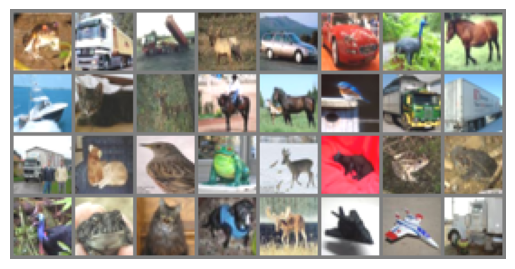

Labels: tensor([6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6,
        2, 6, 3, 5, 4, 0, 0, 9])


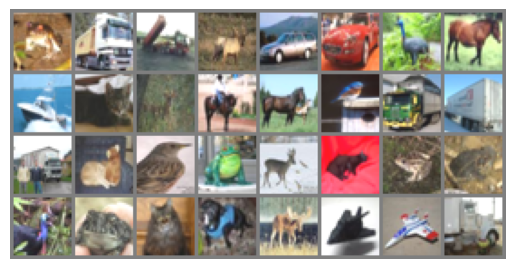

In [ ]:
# Define the function to show images
def imshow(img):
    mean = np.array([0.5, 0.5, 0.5])  # Adjusted mean for a different normalization range
    std = np.array([0.2, 0.2, 0.2])   # Adjusted std for a different normalization range
    img = img.numpy().transpose((1, 2, 0))  # Convert CHW to HWC format

    img = (img * std) + mean

    # Ensure pixel values are in the valid range [0, 1]
    img = np.clip(img, 0, 1)

    plt.imshow(img)
    plt.axis('off')  # Hide axis for better visualization
    plt.show()

transform_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4, 0.4, 0.4), (0.2, 0.2, 0.2))
])

# Load the CIFAR-10 dataset
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_normal)

# Create train loader with shuffle=False
train_loader = DataLoader(train_set, batch_size=128, shuffle=False, num_workers=2)

dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:32]))
print('Labels:', labels[:32])

images_flipped = torch.flip(images[:32], dims=[3])  # Flip horizontally along the last dimension (width)

# Display flipped images
imshow(torchvision.utils.make_grid(images_flipped))


For trainig our models, we first define some functions to make our job easier. fill the functions according to their signature or you can change them according to your needs.

This section defines several functions to train, evaluate, and visualize a PyTorch model. The functions include the training loop, validation loop, loss and accuracy computation, and a function for plotting training and validation losses. The fit_epoch function is also used to execute training or validation for a single epoch.

1. fit_epoch Function
Purpose: Runs one epoch of either training or validation.
Parameters:
model: The neural network model to train or evaluate.
data_loader: The DataLoader providing the dataset.
criterion: The loss function.
optimizer: The optimizer for training.
train_mode: Boolean flag indicating whether it's a training (True) or validation (False) phase.
Implementation:
The model is set to either training (model.train()) or evaluation mode (model.eval()).
In the training phase, gradients are computed (optimizer.zero_grad()), the forward pass is performed, the loss is calculated, and the gradients are propagated back through the network (loss.backward()), followed by the optimization step (optimizer.step()).
For validation, gradients are not calculated (torch.no_grad()), and only the forward pass is performed.
Loss and accuracy are tracked and averaged over all batches in the epoch.
2. train Function
Purpose: Trains the model for a specified number of epochs and validates the model after each epoch.
Parameters:
train_loader: DataLoader for training data.
val_loader: DataLoader for validation data.
model: The neural network model to train.
epochs: Number of epochs to train for.
lr: Learning rate for the Adam optimizer.
Implementation:
The Adam optimizer is used for updating the model's parameters. The CrossEntropy loss function is used for multi-class classification tasks.
The model is moved to the appropriate device (e.g., GPU or CPU).
During each epoch, the model undergoes a training phase where the gradients are updated based on the loss. After each epoch, the validation loss is computed.
Training and validation losses for each epoch are stored in train_losses and val_losses respectively.
3. get_acc Function
Purpose: Computes the accuracy of the model on the validation dataset.
Parameters:
model: The neural network model.
val_loader: DataLoader for validation data.
Implementation:
The model is set to evaluation mode (model.eval()), and predictions are made for each batch in the validation dataset.
The predicted class for each input is compared with the ground truth labels, and the number of correct predictions is accumulated.
The accuracy is computed as the ratio of correct predictions to the total number of samples.
4. plot_losses Function
Purpose: Visualizes the training and validation losses across epochs using a plot.
Parameters:
train_losses: List of training losses.
val_losses: List of validation losses.
c_window: The size of the convolution window for smoothing the training losses.
Implementation:
A moving average is applied to the training losses to smooth out the fluctuations using the specified c_window.
The losses are plotted with raw training losses shown in a dashed line, the smoothed training losses shown in a solid blue line, and the validation losses shown in an orange line.
The plot is labeled with the appropriate axis labels and a title, and a grid is displayed for better readability.
Summary
Training and Validation: The train and fit_epoch functions handle the main training and validation processes. Each epoch consists of forward and backward passes for training, and only forward passes for validation. The model is evaluated after every epoch.
Loss and Accuracy Calculation: The training loss is computed for each batch and averaged over the epoch, while the validation loss is calculated after the training phase. The accuracy is computed at the end of the validation phase.
Visualization: The plot_losses function provides a clear visualization of both training and validation losses across epochs. The smoothed training loss helps in identifying trends, while the validation loss indicates model generalization performance.

In [ ]:
MODEL_SAVE_PATH = './model.pt'


# Assuming global variables 'device' and 'MODEL_SAVE_PATH' are defined elsewhere.

def fit_epoch(
    model: nn.Module,
    data_loader: DataLoader,
    criterion: nn.Module,
    optimizer: Optimizer,
    train_mode: bool = False
) -> List[float]:
    """
    Runs one epoch of training or validation.

    Args:
        model (nn.Module): The PyTorch model to train or evaluate.
        data_loader (DataLoader): The DataLoader for the dataset.
        criterion (nn.Module): Loss function.
        optimizer (Optimizer): Optimizer for training.
        train_mode (bool): Flag indicating training (True) or validation (False).

    Returns:
        List[float]: List of losses for the epoch.
    """
    if train_mode:
        model.train()
    else:
        model.eval()

    losses = []
    total_loss = 0.0
    correct_preds = 0
    total_samples = 0

    context = torch.enable_grad() if train_mode else torch.no_grad()

    with context:
        for batch in tqdm(data_loader, desc="Training" if train_mode else "Validation"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            if train_mode:
                optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())

            if train_mode:
                loss.backward()
                optimizer.step()

            batch_size = inputs.size(0)
            total_loss += loss.item() * batch_size
            correct_preds += (outputs.argmax(dim=1) == labels).sum().item()
            total_samples += batch_size

    average_loss = total_loss / total_samples
    accuracy = correct_preds / total_samples

    mode = "Training" if train_mode else "Validation"
    print(f"{mode} Loss: {average_loss:.4f}, {mode} Accuracy: {accuracy:.4f}")

    return losses


def train(
    train_loader: DataLoader,
    val_loader: DataLoader,
    model: nn.Module,
    epochs: int,
    lr: float = 1e-3
) -> Tuple[List[float], List[float]]:
    """
    Trains a model and validates it after each epoch.

    Args:
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        model (nn.Module): The PyTorch model to train.
        epochs (int): Number of training epochs.
        lr (float): Learning rate for the optimizer.

    Returns:
        Tuple[List[float], List[float]]: Lists of training and validation losses.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Move the model to the appropriate device
    model.to(device)

    # Track losses for each epoch
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        total_train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate training loss
            total_train_loss += loss.item() * inputs.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        print(f"Train Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc="Validation"):
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Accumulate validation loss
                total_val_loss += loss.item() * inputs.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)

        print(f"Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses


def get_acc(
    model: nn.Module,
    val_loader: DataLoader
) -> float:
    """
    Calculates accuracy of the model on a validation dataset.

    Args:
        model (nn.Module): The PyTorch model.
        val_loader (DataLoader): DataLoader for validation data.

    Returns:
        float: Validation accuracy.
    """
    model.eval()

    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            predictions = outputs.argmax(dim=1)

            total_samples += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()

    accuracy = correct_predictions / total_samples
    print(f"Validation Accuracy: {accuracy:.4f}")

    return accuracy



def plot_losses(
    train_losses: List[float],
    val_losses: List[float],
    c_window: int = 10
) -> None:
    """
    Plots training and validation losses.

    Args:
        train_losses (List[float]): List of training losses.
        val_losses (List[float]): List of validation losses.
        c_window (int): Convolution window size for smoothing training losses.

    Returns:
        None
    """
    def moving_average(values: List[float], window: int) -> List[float]:
        return [
            sum(values[i:i + window]) / window
            for i in range(len(values) - window + 1)
        ]

    # Smooth training losses
    smoothed_train = moving_average(train_losses, c_window)

    # Generate x values for smoothed training losses
    smoothed_train_x = list(range(c_window - 1, len(train_losses)))

    # Plot the data
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot raw training loss
    ax.plot(train_losses, label="Training Loss", linestyle="--", alpha=0.6)

    # Plot smoothed training loss
    ax.plot(smoothed_train_x, smoothed_train, label="Smoothed Training Loss", color="blue", linewidth=2)

    # Plot validation loss
    ax.plot(val_losses, label="Validation Loss", color="orange", linewidth=2)

    # Customize the plot
    ax.set_title("Training and Validation Losses", fontsize=16)
    ax.set_xlabel("Epochs", fontsize=12)
    ax.set_ylabel("Loss", fontsize=12)
    ax.legend(loc="upper right", fontsize=10)
    ax.grid(alpha=0.4)

    # Display the plot
    plt.show()

Finally we can start creating the MobileNet model. The architecture is presented here:
![architecture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-22_at_4.26.15_PM_ko4FqXD.png)

You can see the related paper [here](https://arxiv.org/abs/1704.04861)

for cleaner implementation first complete these functions(Each layer consists of a depthwise separable convolution followed by a ReLU activation. The architecture efficiently reduces computations by using depthwise separable convolutions, making it suitable for mobile and embedded applications.):

1. conv_bn Function
Purpose: Defines a standard convolutional block with batch normalization and ReLU activation.
Parameters:
inp: Number of input channels (depth of the input tensor).
oup: Number of output channels (depth of the output tensor).
stride: Stride size for the convolution operation, which controls the step size the filter takes when sliding over the input.
Implementation:
The function returns a sequential block that consists of three layers:
Convolutional Layer (nn.Conv2d): Applies a 2D convolution with a kernel size of 3x3 and padding of 1 (to maintain spatial dimensions). The bias=False argument is used because the bias is handled by batch normalization.
Batch Normalization Layer (nn.BatchNorm2d): Normalizes the output of the convolutional layer, helping to stabilize and accelerate training by reducing internal covariate shift.
ReLU Activation (nn.ReLU): Applies the ReLU activation function to introduce non-linearity in the model. The inplace=True argument modifies the input tensor directly, saving memory.
2. conv_dw Function
Purpose: Defines a depthwise separable convolution block, which reduces the number of parameters compared to a standard convolution.
Parameters:
inp: Number of input channels (depth of the input tensor).
oup: Number of output channels (depth of the output tensor).
stride: Stride size for the depthwise convolution.
Implementation:
The function returns a sequential block with two main components:
Depthwise Convolution (nn.Conv2d): This performs the convolution separately for each input channel. It has groups=inp, meaning that each input channel is convolved with its own filter, reducing the number of parameters compared to a standard convolution.

Batch Normalization (nn.BatchNorm2d): Normalizes the output of the depthwise convolution.

ReLU Activation (nn.ReLU): Introduces non-linearity after the depthwise convolution.

Pointwise Convolution (nn.Conv2d): A 1x1 convolution is applied to combine the output from the depthwise convolution and increase the number of output channels. This layer also uses batch normalization and ReLU activation.

In [ ]:
def conv_bn(inp, oup, stride):
    # Define a standard convolutional layer with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the convolution
    return nn.Sequential(
        nn.Conv2d(inp, oup, kernel_size=3, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )


def conv_dw(inp, oup, stride):
    # Define a depthwise separable convolution layer
    # Consists of depthwise convolution followed by pointwise convolution, each with batch normalization and ReLU activation
    # Parameters:
    # inp: Number of input channels
    # oup: Number of output channels
    # stride: Stride size for the depthwise convolution
    return nn.Sequential(
        # Depthwise convolution
        nn.Conv2d(inp, inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        # Pointwise convolution (1x1 convolution)
        nn.Conv2d(inp, oup, kernel_size=1, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

Explain how using Depthwise Separable Convolutions helps us in reducing the number of parameters(calculate and compare number of parameters in normal convolution and depthwise convolution) and how it helps us in making the model faster.


**answer**

Now please create your model.

The MobileNet class is a lightweight convolutional neural network (CNN) model designed for mobile and embedded devices. It utilizes depthwise separable convolutions to reduce computation cost and model size, making it more efficient than traditional convolutions.

Key Components:
Features:

A series of convolutional layers built using conv_bn and conv_dw blocks.
Starts with a standard convolution (conv_bn(3, 32, stride=2)) followed by depthwise separable convolutions (conv_dw).
The network progressively increases the number of output channels, with layers like conv_dw(128, 256, stride=2) and conv_dw(1024, 1024, stride=1).
Ends with a Global Average Pooling (GAP) layer (nn.AdaptiveAvgPool2d(1)) that reduces the spatial dimensions to 1x1.
Classifier:

A fully connected (FC) layer with dropout for regularization, followed by a linear layer for classification.
Forward Pass:
Input passes through the feature extraction layers, which reduce spatial dimensions and extract high-level features.
The output is flattened and passed through the classifier to produce final class predictions.

In [ ]:
class MobileNet(nn.Module):
    def __init__(self, n_class=1000):
        super(MobileNet, self).__init__()

        # Define the layers
        self.features = nn.Sequential(
            # Initial Conv1 layer
            conv_bn(3, 32, stride=2),

            # Depthwise separable convolutions
            conv_dw(32, 64, stride=1),
            conv_dw(64, 128, stride=2),
            conv_dw(128, 128, stride=1),
            conv_dw(128, 256, stride=2),
            conv_dw(256, 256, stride=1),
            conv_dw(256, 512, stride=2),

            # 2x depthwise separable convolutions with 512 output channels
            conv_dw(512, 512, stride=1),
            conv_dw(512, 512, stride=1),

            # More layers for higher capacity
            conv_dw(512, 1024, stride=2),
            conv_dw(1024, 1024, stride=1),

            # Global Average Pooling layer
            nn.AdaptiveAvgPool2d(1)
        )

        # Fully Connected layer for classification
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, n_class)
        )

    def forward(self, x):
        # Forward pass through features and classifier
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output from the features
        x = self.classifier(x)
        return x

Let's train your model.(You can increase number of epochs or change lr but your accuracy should be above 65 and calculate training time)

Model Initialization:
The MobileNet model is instantiated with n_class=10 to match the CIFAR-10 dataset's 10 classes and moved to the appropriate device (GPU or CPU).
Training and Validation:
The model is trained using the train function, which performs both training and validation across the specified epochs.
Training and validation losses are tracked for each epoch, and the model updates its weights based on the training loss.

In [ ]:
epochs = 10
lr = 1e-3
# TODO:

c_model = MobileNet(n_class=10).to(device)
tr_loss, val_loss = train(train_l, val_l, c_model, epochs, lr)



Epoch 1/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.7923


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 1.3153
Epoch 2/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.6089


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 1.1119
Epoch 3/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.5213


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.9321
Epoch 4/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.4575


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.8232
Epoch 5/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.4039


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.7656
Epoch 6/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.3646


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.6820
Epoch 7/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.3371


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.6478
Epoch 8/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.3085


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.6132
Epoch 9/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.2957


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.5843
Epoch 10/10


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.2731


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 0.5464


Get some metrics and plot your losses.

Validation Accuracy: 0.8140
Batch_size=128, epochs=10, lr=0.001
Val accuracy = 0.814
Process validation time: 27.0952 s


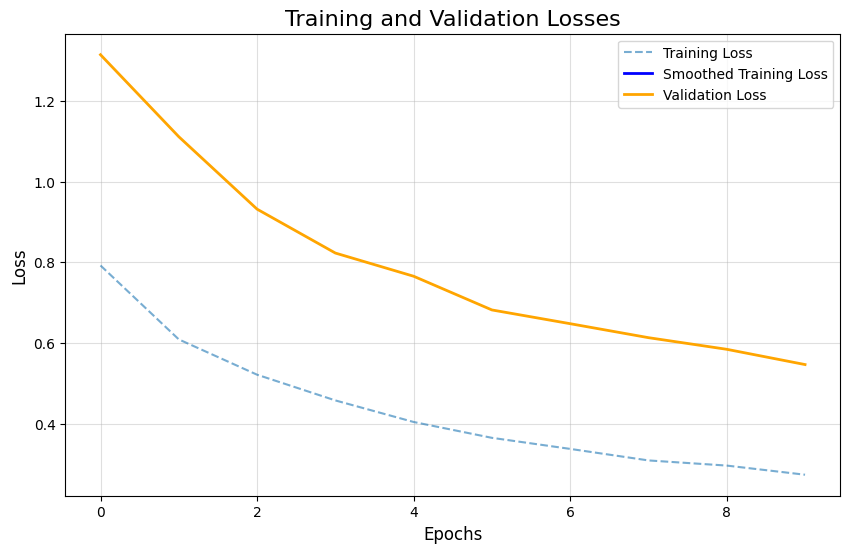

In [ ]:
start = time.time()
val_acc = get_acc(c_model, val_l)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(tr_loss, val_loss)

The MobileNet paper claims it is 8 to 9 times faster than standard convolution. Using the theoretical computations of FLOPs for standard convolution and depthwise separable convolution, explain how this number was calculated.


**answer**

## 2.Normal CNN
In this part, we will give you a new architecture that is like MobileNet. But this time we will use normal CNN. The model is implemented and you should train it for 2 epochs. So now you can compare its speed in training and validating with your MobileNet.(Note that the accuracy is not important in this part)

In [ ]:
class NormalCNN(nn.Module):
    def __init__(self, n_class=1000):
        super().__init__()


        self.model = nn.Sequential(
            conv_bn(  3,  32, 2),
            conv_bn( 32,  64, 1),
            conv_bn( 64, 128, 2),
            conv_bn(128, 128, 1),
            conv_bn(128, 256, 2),
            conv_bn(256, 256, 1),
            conv_bn(256, 512, 2),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 512, 1),
            conv_bn(512, 1024, 2),
            conv_bn(1024, 1024, 1),
            nn.AvgPool2d(7),
        )
        self.fc = nn.Linear(1024, n_class)

    def forward(self, x):
        x = self.model(x)
        x = x.view(-1, 1024)
        x = self.fc(x)
        return x

Model Initialization:
The NormalCNN model is instantiated with n_class=20 to match the dataset's 20 classes and moved to the appropriate device.
Training and Validation:
The model is trained using the train function for 2 epochs, with training and validation losses computed at each epoch.
The model's weights are updated based on the training loss, and performance is evaluated on the validation set.

In [ ]:
# TODO: train model
epochs = 2
lr = 1e-3
# TODO:

c_model = NormalCNN(n_class=20).to(device)
tr_loss, val_loss = train(train_l, val_l, c_model, epochs, lr)

Epoch 1/2


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.9665


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 1.7596
Epoch 2/2


Training:   0%|          | 0/391 [00:00<?, ?it/s]

Train Loss: 0.8677


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Val Loss: 1.5809


Validation Accuracy: 0.4124
Batch_size=128, epochs=2, lr=0.001
Val accuracy = 0.4124
Process validation time: 34.0475 s


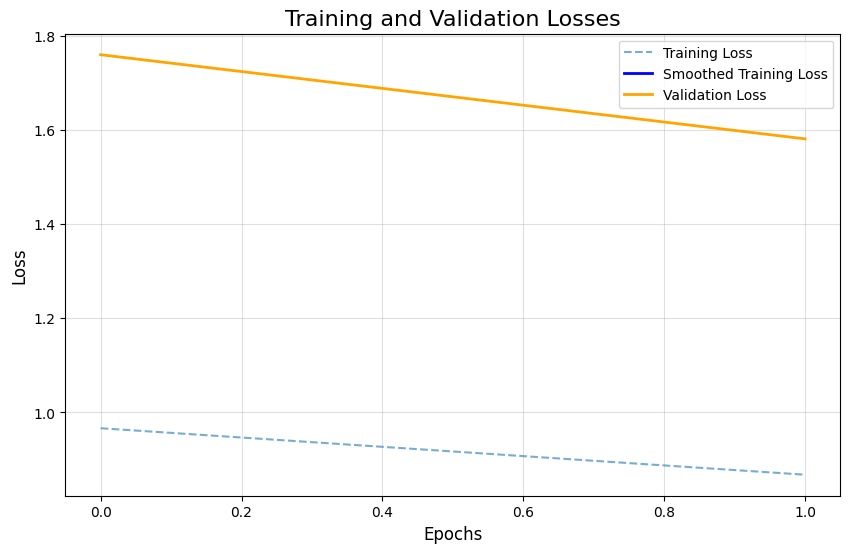

In [ ]:
start = time.time()
val_acc = get_acc(c_model, val_l)
end = time.time()

print('Batch_size={}, epochs={}, lr={}'.format(128, epochs, lr))
print('Val accuracy =', val_acc)
print("Process validation time: {:0.4f} s".format(end - start))

plot_losses(tr_loss, val_loss)

Compare speed of learning and validating in normal CNN vs MobileNet

**answer**

The number of parameters in two models, NormalCNN and MobileNet, was compared.

Key Actions:
Parameter Counting:

The count_parameters function was used to calculate the total number of parameters for both models.
Instances of NormalCNN and MobileNet were created with n_class=10 and moved to the appropriate device.
Output:

The total number of parameters for both models was printed.

In [ ]:
# TODO: compare number of parameters in these two models
def count_parameters(model):
    """Counts the total number of parameters in a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model.

    Returns:
        int: The total number of parameters.
    """
    return sum(p.numel() for p in model.parameters())


# Create instances of the models and move them to the device
normalmodel = NormalCNN(n_class=10).to(device)
mobilenet_model = MobileNet(n_class=10).to(device)

# Count and print the parameters
normal_cnn_params = count_parameters(normalmodel)
mobilenet_params = count_parameters(mobilenet_model)

print(f"Total number of Normal CNN parameters: {normal_cnn_params}")
print(f"Total number of MobileNet parameters: {mobilenet_params}")

Total number of Normal CNN parameters: 28279338
Total number of MobileNet parameters: 2410826


Explain how this hyperparameter changes the number of parameters in theory. Write a formula to predict its effect without actually creating the models. Compare your formula with the above numbers and if they dont match perfectly explain a bit.

**answer**

Another hyperparameter is resolution multiplier. Can it make our model faster? Does it decrease the number of parameters? Explain.

**answer**

Why is the number of parameters important for us? Now we have GPUs that can increase performance considerably. Is the number of parameters really a big deal?

**answer**

## Summary
- **MobileNet V1**: Introduced depthwise separable convolutions, significantly reducing computation and model size.

These architectures are optimized for mobile and embedded applications, providing a balance between accuracy and efficiency through lightweight, effective design.

question for yourself: What new features and innovations did MobileNetV3 introduce to improve both efficiency and accuracy over its predecessors? Explore its design choices and how they further optimize MobileNet for real-time applications and mobile deployment.

### Speciall thanks to [Amirmahdi Meighani](https://www.linkedin.com/in/amirmm03/) (notebook main author)

## Refrences

[1] Andrew G. Howard, Menglong Zhu, Bo Chen,
Dmitry Kalenichenko, Weijun Wang, Tobias
Weyand, Marco Andreetto, and Hartwig Adam. Mobilenets: Efficient convolutional neural networks for mobile vision applications. CoRR,
abs/1704.04861, 2017

[2] Mark Sandler, Andrew G. Howard, Menglong Zhu, Andrey
Zhmoginov, and Liang-Chieh Chen. Mobilenetv2: Inverted
residuals and linear bottlenecks. mobile networks for classification, detection and segmentation. CoRR, abs/1801.04381,
2018